<h3> PUBG Game Prediction </h3>

<b> Importing Libraries </b>

In [1]:
# handling warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%pip install catboost
import catboost as cb

     -------------------------------------- 101.0/101.0 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<b> Reading the Data</b>

In [34]:
df = pd.read_csv("PUBG_Game_Prediction_data.csv")
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [3]:
df.shape

(4446966, 29)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

<h3><b> Data Wrangling </b><h3>

In [5]:
# check row with NULL win prediction value
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [35]:
# remove the data row
df.drop(2744604, inplace = True)

# or we can --> df = df.drop(2744604)

<b> Understanding Players distribution in a game</b>

In [37]:
# prepare new parameter to know how many players are in a game
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.00,0,0,244.80,1,1466,0.4444,244.8000,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,11.04,0,0,1434.00,5,0,0.6400,1445.0445,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.00,0,0,161.80,2,0,0.7755,161.8000,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.00,0,0,202.70,3,0,0.1667,202.7000,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.00,0,0,49.75,2,0,0.1875,49.7500,97


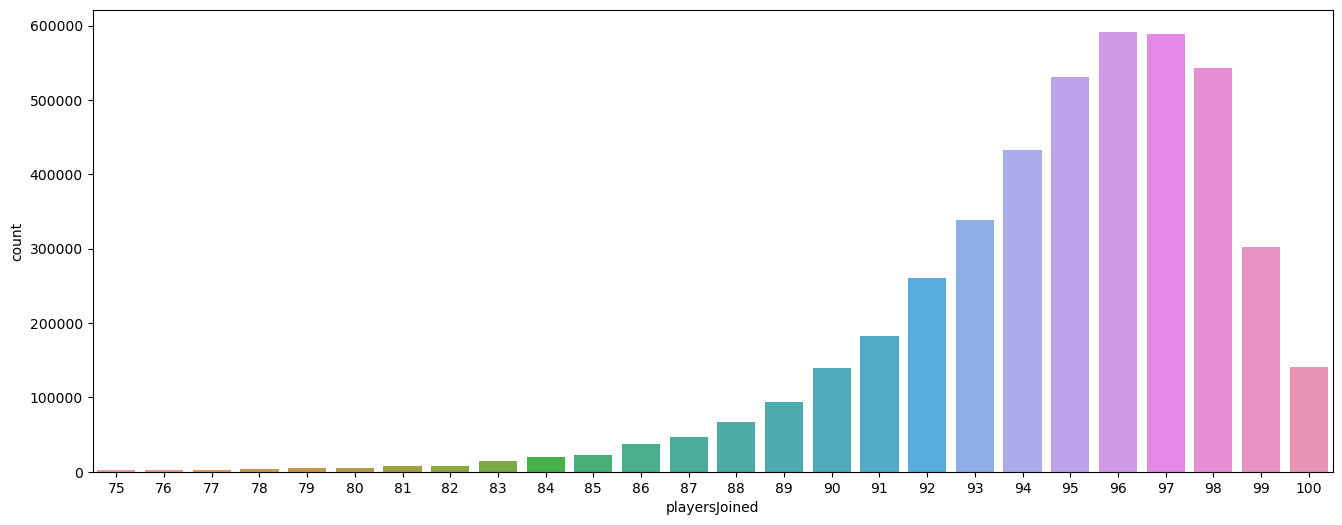

In [31]:
sns.countplot(x=df[df['playersJoined']>=75]['playersJoined'])
plt.show()

<h3> Analysing the data</h3>

In [36]:
# data parameter for total distance travelled
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

<b> Killing without moving</b><br><br>We want our model to function on valid and true data only.<br>
If any player has 1 or more kills but has travelled 0 distance, this is an anamoly which needs to be removed.

In [39]:
# data parameter to check for anamoly detection that
# the person has not moved but still managed to do the kills
df['killswithoutMoving'] = ((df['kills']>0) & (df['totalDistance'] ==0))

print(df[df['killswithoutMoving'] == True].shape)
df[df['killswithoutMoving'] == True].head()

(1535, 32)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,playersJoined,killswithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,0.0,58,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,0.0,42,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,0.0,21,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,0.0,73,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,0.0,42,True


In [40]:
# drop the table
df.drop(df[df['killswithoutMoving'] == True].index , inplace = True)

<b> Very high roadkills</b><br><br>
Another anamoly or invalid data entry could be when a player has high number of roadkills. <br>Roadkills is the number of kills while in a vehicle or via a vehicle. We will remove such rows as well.

In [41]:
print(df[df['roadKills'] > 5].shape)
df[df['roadKills'] > 5].head()

(46, 32)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,playersJoined,killswithoutMoving
39338,0097d2ae7a8576,b61edfa0c228d4,a786011fe206e9,1,2,495.7,4,0,0,2,...,0.0,0,0,72.80,1,0,0.9362,5202.80,92,False
90312,0e6ea81fd1b9b3,1e96ac916d6fbb,3f150f3834422c,2,6,190.0,0,0,5,2,...,0.0,0,1,976.80,4,0,0.9556,4257.80,89,False
197752,6cf1efa197bcc1,28df010b29a9e2,2e40495266529f,0,2,800.0,5,0,4,1,...,0.0,0,0,1516.00,3,0,0.6538,10085.00,89,False
209676,5df28fce2b8128,32a01a5517635a,ee9fb50eb0fe00,0,3,360.0,2,0,4,1,...,0.0,0,0,36.96,0,0,1.0000,6142.96,59,False
213544,612ee3024560a3,ab0162b0300c59,7c5535bfd43592,1,2,426.3,3,0,0,1,...,0.0,0,0,128.30,3,0,0.9167,3607.30,96,False


In [42]:
df.drop(df[df['roadKills'] > 5].index, inplace = True)

<b>Unrealistical number of kills</b>

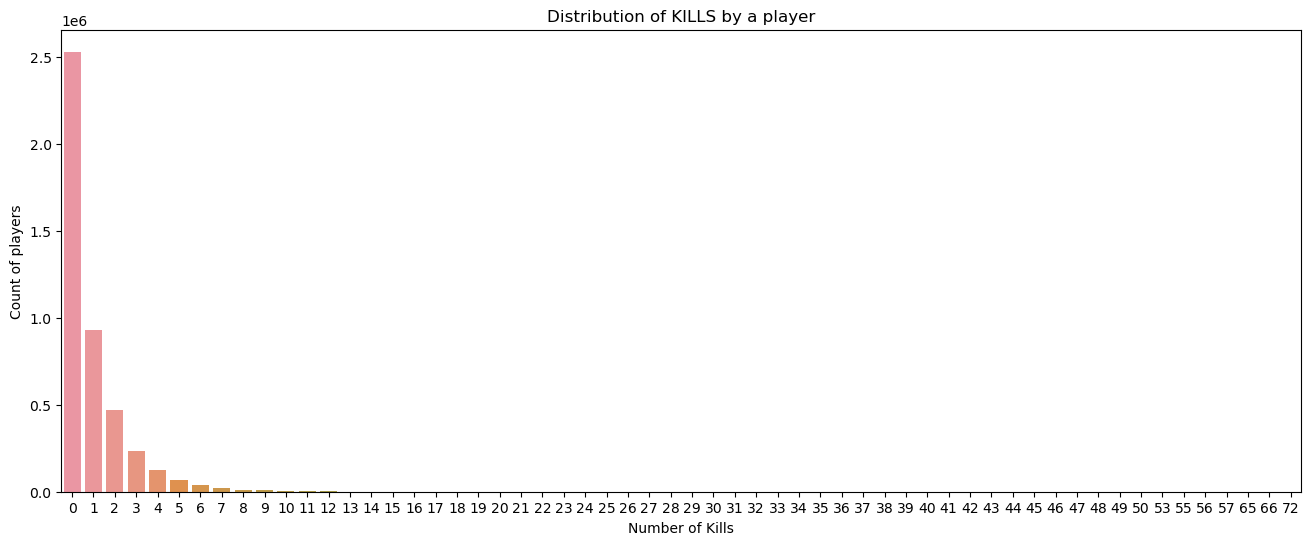

In [17]:
sns.countplot(data = df, x = df['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

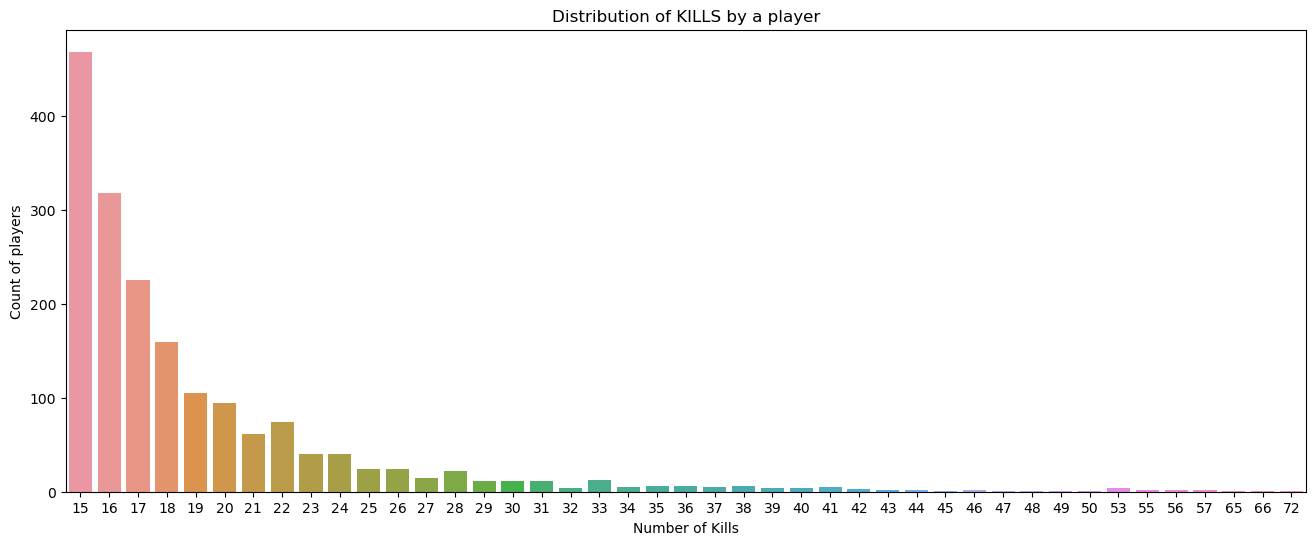

In [43]:
# Let us magnify our graph a little
sns.countplot(df[df['kills']>=15]['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

It is visible that having kills higher than 20 is very unlikely and if probably and anamoly so we remove those as well.

In [45]:
# drop the instances
df.drop(df[df['kills'] > 20].index, inplace = True)

<b> Number of Headshots and Headshot rate</b>

In [46]:
# new parameter
df['headshot_rate'] = df['headshotKills']/df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

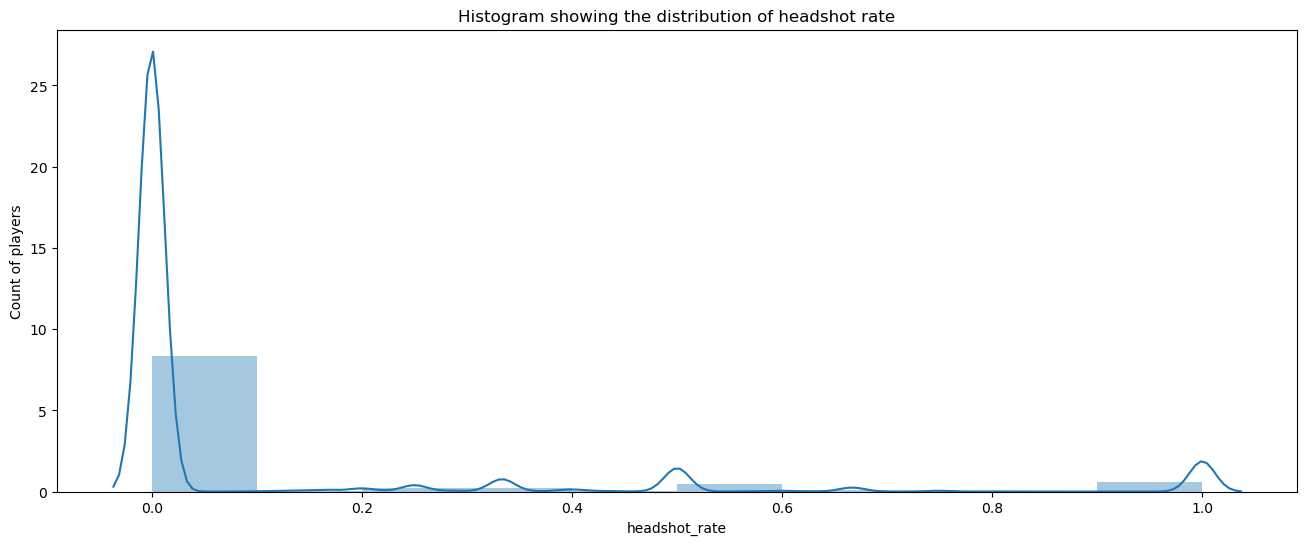

In [47]:
# plot the headshot rate distribution
sns.distplot(df['headshot_rate'], bins =10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [49]:
# more than 5 kills, all headshots --> anamoly
print(df[(df['headshot_rate'] ==1) & (df['kills']>5)].shape)

# Drop instances
df.drop(df[(df['headshot_rate'] == 1)& (df['kills'] > 6)].index, inplace = True)

(187, 33)


<b> Longest shots</b><br>
It is the longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

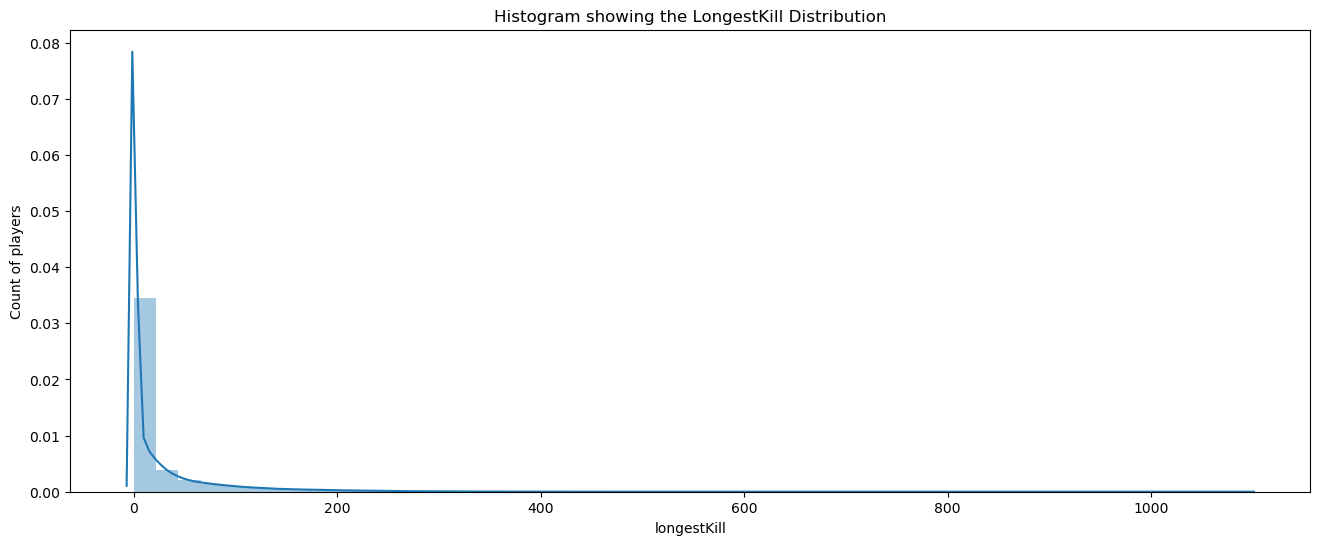

In [50]:
sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the LongestKill Distribution")
plt.ylabel("Count of players")
plt.show()

In [51]:
# longest kill further than 500m --> not posiible
print(df[df['longestKill']>=500].shape)

# Drop such instances
df.drop(df[df['longestKill']>=500].index, inplace = True)

(1747, 33)


<b>Weapon Change</b>

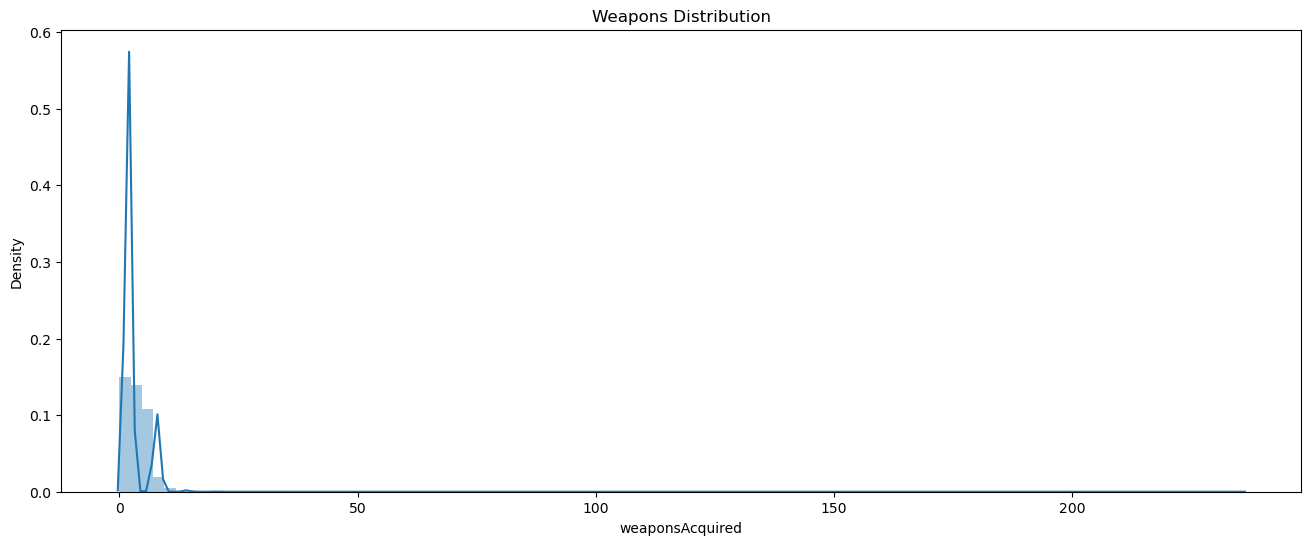

In [52]:
sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [53]:
# Changing weapons more than 15 times --> anamoly
print(df[df['weaponsAcquired']>=15].shape)

# Dropsuch instances
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

(6809, 33)


<hr>
<h3> Exploratory Data Analysis</h3>

In [54]:
df.shape

(4436306, 33)

In [55]:
df.isna().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
totalDistance         0
playersJoined         0
killswithoutMoving    0
headshot_rate         0
dtype: int64

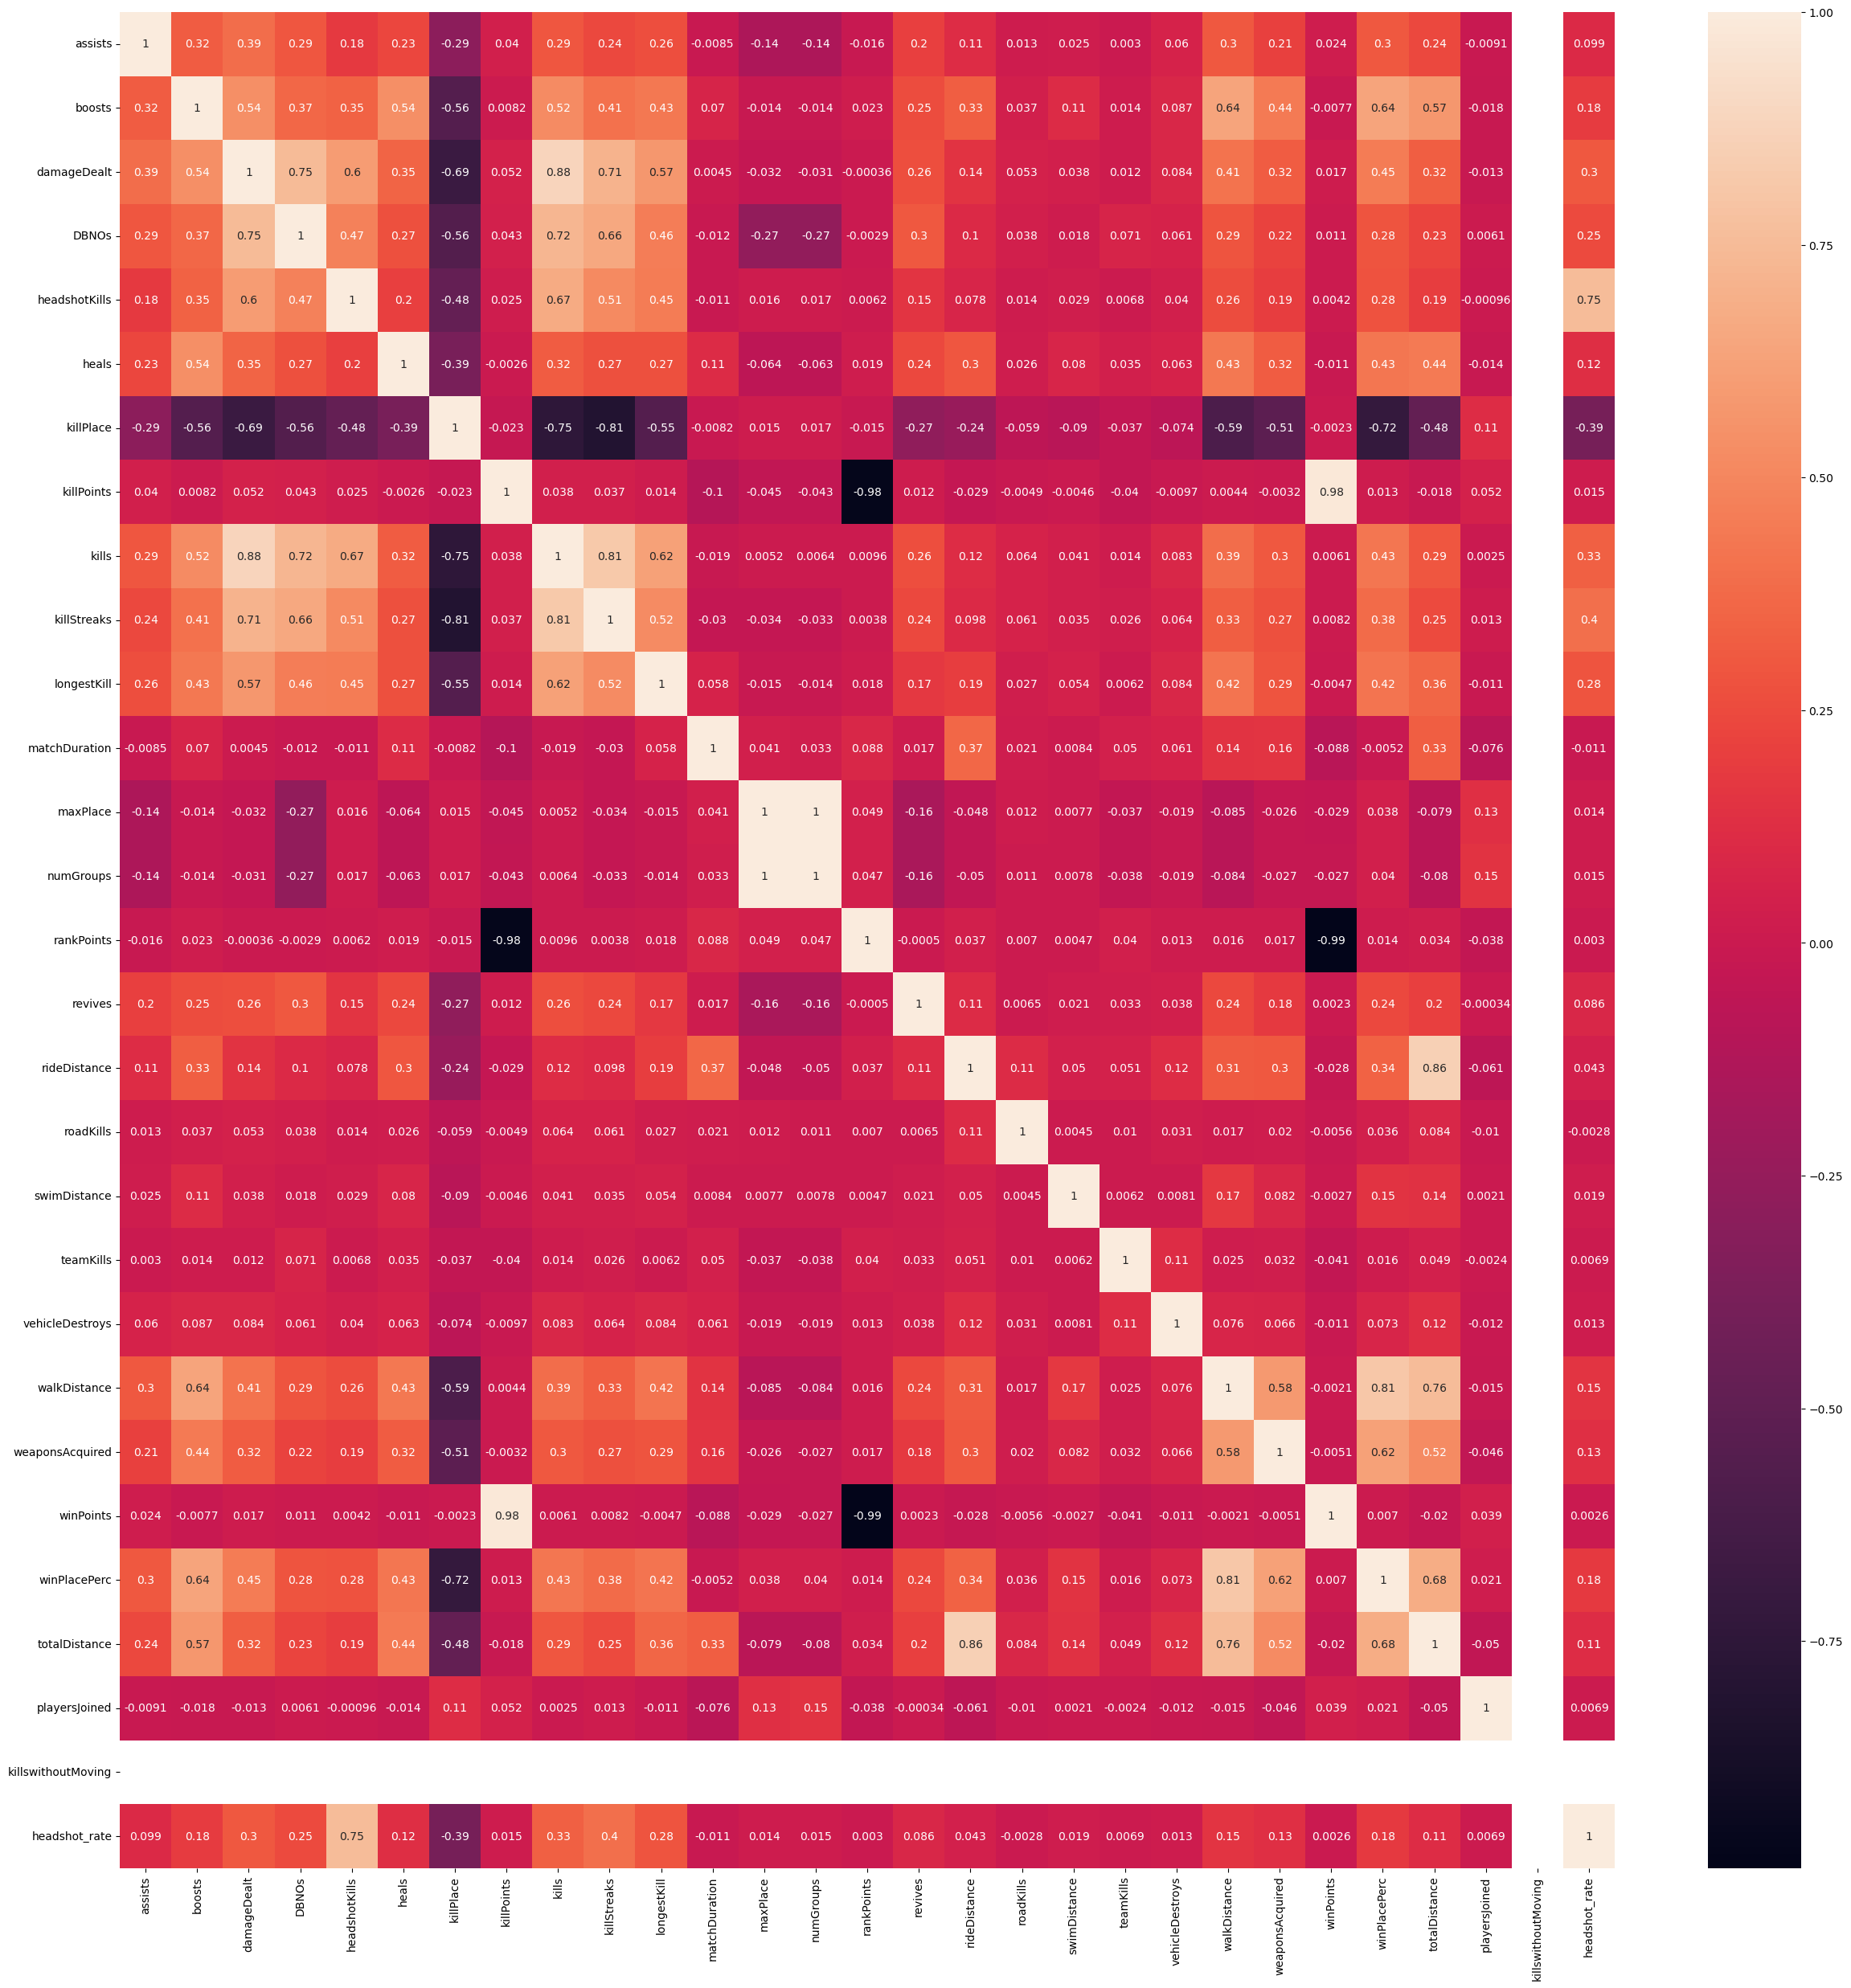

In [56]:
# correlation of parameter with Win Prediction
plt.figure(figsize=[30,30])
sns.heatmap(df.corr(), annot = True)
plt.show()

<hr>
<h3> Feature Engineering</h3>

Say a Player A has 20 kills in a match of total 50 players and Player B has 20 kills in a match of 25 player. While the number kills are same for both A and B, A clearly is a better player in this scenario. This is one example of many.

To deal with such cases, we are going to normalise the relevant columns:
- kills - Number of enemy players killed.
- damageDealt - Total damage dealt.
- maxPlace - Worst placement we have data for in the match.
- matchDuration - Duration of match in seconds.

In [57]:
normalising_factor = (100 - df['playersJoined']/100) +1

df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor

df['traveldistance'] = df['walkDistance'] + df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [58]:
# Drop unneccery columns
data = df.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance', 
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])

In [59]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,playersJoined,killswithoutMoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,96,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,91,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,98,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,91,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,97,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


<hr>
<h3>ML - Catboost Model</h3>
CatBoost is an algorithm for gradient boosting on decision trees. It converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features.

Handling Categorical Data

In [65]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

x = pd.get_dummies(x, columns = ['matchType', 'killswithoutMoving'])
features = x.columns

print(x.shape)
x.head()

(4436306, 40)


,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


In [66]:
# Scaling the Data
sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.765100,-0.459622,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.765100,-0.459622,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
2,-0.582937,-0.384018,-0.024245,-0.804728,-0.765100,-0.459622,0.169557,0.813067,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,-0.808936,0.0
3,-0.582937,-0.384018,0.995795,-0.804728,-0.765100,-0.459622,-0.560992,0.700391,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
4,-0.582937,-0.384018,-0.097105,-0.804728,0.647633,0.727371,2.232284,0.906738,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,2.696896,-0.405071,-0.808936,0.0


In [67]:
# Splitting Data
xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size = 0.3, random_state = 0)

print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(3105414, 40) (3105414,)
(1330892, 40) (1330892,)


Model Deployment

In [68]:
import catboost as cb

train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

model = cb.CatBoostRegressor(loss_function='RMSE')

# GRID Search
grid = {'iterations': [100, 150], 
       'learning_rate': [0.03, 0.1], 
       'depth': [2, 4, 6, 8]}

model.grid_search(grid, train_dataset)

0:	learn: 0.5482027	test: 0.5479936	best: 0.5479936 (0)	total: 1.08s	remaining: 1m 47s
1:	learn: 0.5333453	test: 0.5331431	best: 0.5331431 (1)	total: 1.7s	remaining: 1m 23s
2:	learn: 0.5189917	test: 0.5187970	best: 0.5187970 (2)	total: 2.37s	remaining: 1m 16s
3:	learn: 0.5050722	test: 0.5048840	best: 0.5048840 (3)	total: 3.15s	remaining: 1m 15s
4:	learn: 0.4916269	test: 0.4914461	best: 0.4914461 (4)	total: 3.89s	remaining: 1m 13s
5:	learn: 0.4785903	test: 0.4784153	best: 0.4784153 (5)	total: 4.5s	remaining: 1m 10s
6:	learn: 0.4660109	test: 0.4658457	best: 0.4658457 (6)	total: 5.15s	remaining: 1m 8s
7:	learn: 0.4538376	test: 0.4536776	best: 0.4536776 (7)	total: 5.8s	remaining: 1m 6s
8:	learn: 0.4420165	test: 0.4418586	best: 0.4418586 (8)	total: 6.43s	remaining: 1m 4s
9:	learn: 0.4306216	test: 0.4304702	best: 0.4304702 (9)	total: 6.99s	remaining: 1m 2s
10:	learn: 0.4195838	test: 0.4194391	best: 0.4194391 (10)	total: 7.59s	remaining: 1m 1s
11:	learn: 0.4089063	test: 0.4087652	best: 0.4087

{'params': {'depth': 8, 'iterations': 150, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [69]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)

feature_importance_df

,features,importance
2,killPlace,40.420521
20,traveldistance,15.697885
13,totalDistance,8.955328
16,killsNorm,8.807126
4,killStreaks,6.176599
19,matchDurationNorm,5.234490
14,playersJoined,4.784708
6,numGroups,2.464019
5,longestKill,2.186875
21,healsnboosts,1.777154


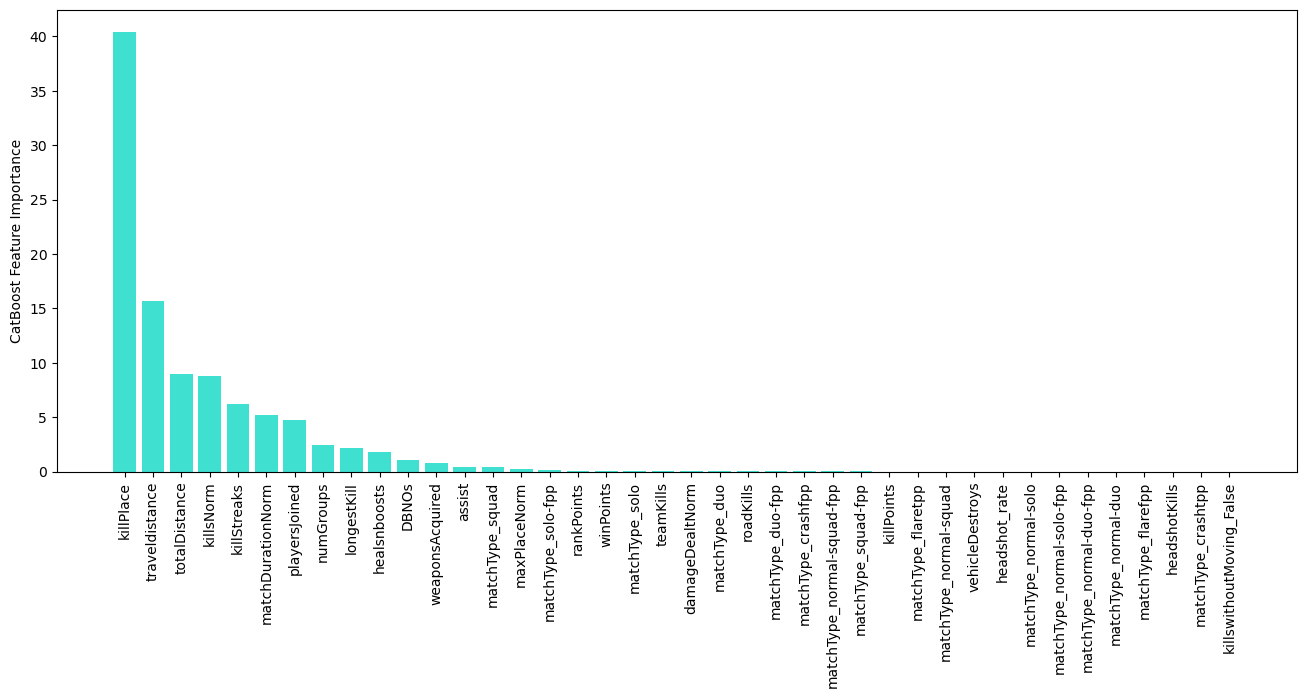

In [70]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color='turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()

<h3> Predictions </h3>

In [72]:
pred = model.predict(xtest)

rmse = np.sqrt(mean_squared_error(ytest, pred))
r2 = r2_score(ytest, pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.08
R2: 0.93


We can see that RMSE is almost 0 and the R2 is quite high indicating the model is working nicely!

<hr>